# Multivariate Normal Likelihood with Multivariate Normal Prior

This is a simple model where our data, $y$, is modelled as a multivariate normal RV with uncorrelated noise.

$L(x) = p(y | x) = \mathcal{N}[y \mid x,\Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu, \sigma^2 \mathbf{I}]$.

The analytic evidence for this model is,

$Z = p(y) = \mathcal{N}[y \mid \mu, \Sigma + \sigma^2 \mathbf{I}]$

The posterior is also a multivariate normal distribution,

$p(x \mid y) = \mathcal{N}[\mu', \Sigma']$

where

$\mu' = \sigma^2 \mathbf{I} (\sigma^2 \mathbf{I} + \Sigma)^{-1} y + \Sigma (
    \sigma^2 \mathbf{I} + \Sigma)^{-1}  \mu$

and

$\Sigma' = \sigma^2 \mathbf{I}  (\sigma^2 \mathbf{I}  + \Sigma)^{-1} \Sigma$


In [1]:

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior

tfpd = tfp.distributions

INFO[2023-12-11 13:47:05,607]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:47:05,608]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:47:05,609]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 13:47:05,610]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from jax._src.scipy.linalg import solve_triangular


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    return -0.5 * x.size * jnp.log(2. * jnp.pi) - jnp.sum(jnp.log(jnp.diag(L))) - 0.5 * dx @ dx


# define our data and prior
ndims = 3
prior_mu = 2 * jnp.ones(ndims)
prior_cov = jnp.diag(jnp.ones(ndims)) ** 2

data_mu = jnp.zeros(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.99, data_cov)

true_logZ = log_normal(data_mu, prior_mu, prior_cov + data_cov)

J = jnp.linalg.solve(data_cov + prior_cov, prior_cov)
post_mu = prior_mu + J.T @ (data_mu - prior_mu)
post_cov = prior_cov - J.T @ (prior_cov + data_cov) @ J

print("True logZ={}".format(true_logZ))
print("True post_mu={}".format(post_mu))
print("True post_cov={}".format(post_cov))


True logZ=-4.964944362640381
True post_mu=[1.4974875 1.4974873 1.4974874]
True post_cov=[[0.25618196 0.24628097 0.24628086]
 [0.24628094 0.25618184 0.24628094]
 [0.24628088 0.24628098 0.2561819 ]]


In [3]:



def prior_model():
    x = yield Prior(tfpd.MultivariateNormalTriL(loc=prior_mu, scale_tril=jnp.linalg.cholesky(prior_cov)), name='x')
    return x


# The likelihood is a callable that will take
def log_likelihood(x):
    return log_normal(x, data_mu, data_cov)


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)


In [4]:

# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(model=model,
                          max_samples=1e5)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)

# We can always save results to play with later
ns.save_results(results, 'save.npz')
# loads previous results by uncommenting below
# results = load_results('save.npz')



/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 52601
samples: 2592
phantom samples: 1056.0
likelihood evals / sample: 20.3
phantom fraction (%): 40.7%
--------
logZ=-5.16 +- 0.21
H=5.8
ESS=368.3704528808594
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 1.49 +- 0.49 | 0.9 / 1.45 / 2.15 | 1.46 | 0.03
x[1]: 1.5 +- 0.48 | 0.93 / 1.46 / 2.15 | 1.46 | 0.04
x[2]: 1.49 +- 0.5 | 0.91 / 1.45 / 2.12 | 1.47 | 0.04
--------


WARNING[2023-12-11 13:47:14,468]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


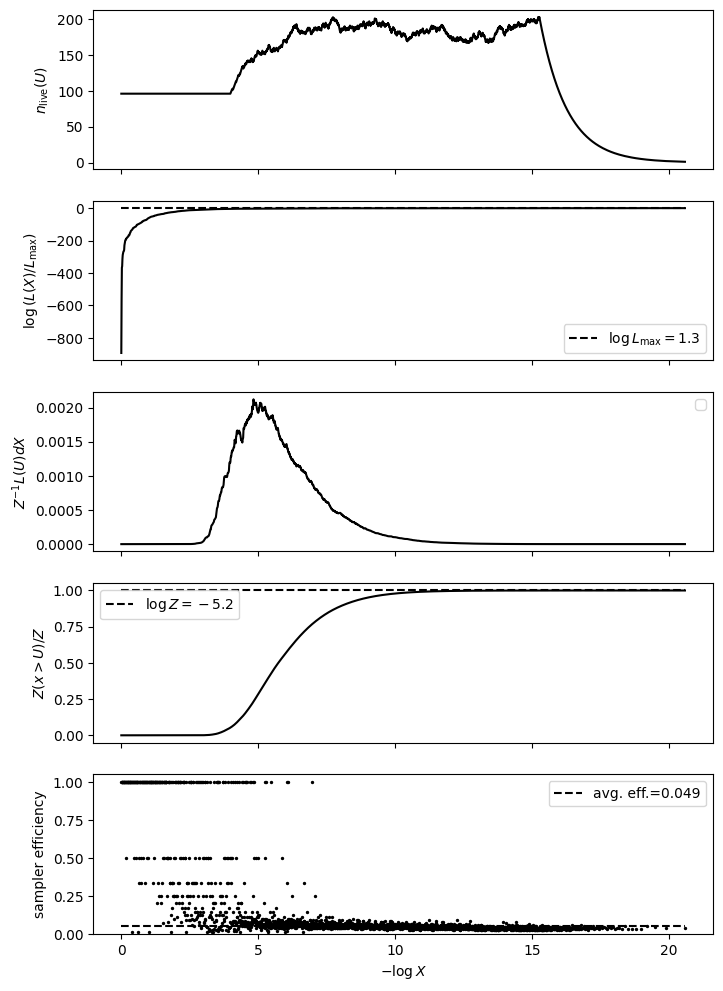

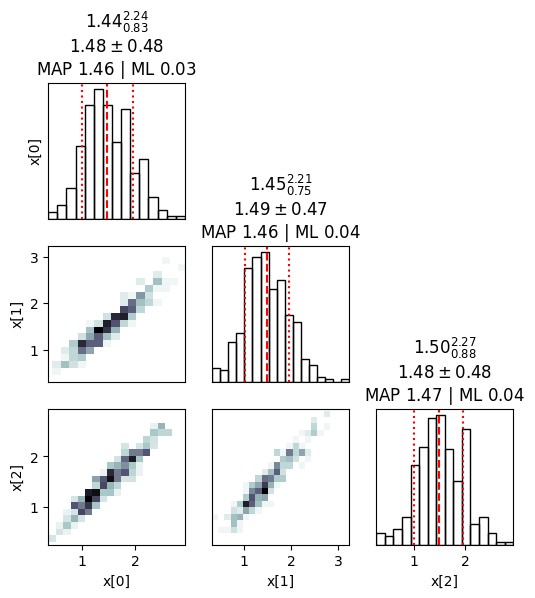

In [5]:
# We can use the summary utility to display results
ns.summary(results)
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)

In [6]:

import jax
from time import perf_counter

ns_compiled = jax.jit(ns).lower(random.PRNGKey(0)).compile()
t0 = perf_counter()
termination_reason, state = ns_compiled(random.PRNGKey(42))
print(f"Time to execute: {perf_counter() - t0} seconds")
results = ns.to_results(termination_reason=termination_reason, state=state)

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Time to execute: 0.35865568497683853 seconds


In [7]:
from jaxns import marginalise_dynamic


# Let us now consider how to marginalise over the posterior.

def param_mean(x):
    return x


post_mean = marginalise_dynamic(random.PRNGKey(42),
                                samples=results.samples,
                                log_weights=results.log_dp_mean,
                                ESS=results.ESS,
                                fun=param_mean)


def param_covariance(x):
    dx = x - post_mean
    return jnp.outer(dx, dx)


post_covariance = marginalise_dynamic(random.PRNGKey(42),
                                      samples=results.samples,
                                      log_weights=results.log_dp_mean,
                                      ESS=results.ESS,
                                      fun=param_covariance)

print(f"Estimated posterior mean:\n{post_mean}")
print(f"True posterior mean:\n{post_mu}")

print(f"Estimated posterior covariance:\n{post_covariance}")
print(f"True posterior covariance:\n{post_cov}")

Estimated posterior mean:
[1.4633472 1.4684827 1.469077 ]
True posterior mean:
[1.4974875 1.4974873 1.4974874]
Estimated posterior covariance:
[[0.22972012 0.22169666 0.22302943]
 [0.22169666 0.23270346 0.2269387 ]
 [0.22302943 0.2269387  0.2388129 ]]
True posterior covariance:
[[0.25618196 0.24628097 0.24628086]
 [0.24628094 0.25618184 0.24628094]
 [0.24628088 0.24628098 0.2561819 ]]
